# Peta laboratorijska vježba - Normalizirajući tokovi

U ovoj laboratorijskoj vježbi koristit ćemo biblioteku normflows koja omogućuje jednostavnu implementaciju normalizirajućih tokova.
Dokumentacija je dostupna na <a href="https://vincentstimper.github.io/normalizing-flows">linku.</a>

U ovoj laboratorijskoj vježbi proučit će se normalizirajući tokovi, generativni modeli bazirani na toku. Generativni modeli bazirani na toku složeni su od niza invertibilnih transformacija. Za razliku od GAN-ova, oni eksplicitno uče distribuciju podataka $p(x)$ i zbog toga se kao funkcija gubitka koristi negativna log vjerojatnost.

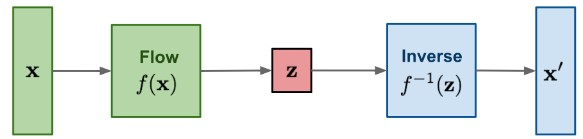

Za razliku od drugih generativnih mreža, svi slojevi su invertibilni, čime se omogućava bijektivno mapiranje između distribucije podataka $p(x)$ i latentne distribucije $p(z)$, koju uobičajeno biramo kao Gaussovu distribuciju. Invertibilno mapiranje podrazumijeva da za svaki uzorak $x$ postoji njemu odgovarajuća latentna varijabla $z$. Zbog toga je odabir arhitekture ograničeniji, ali istovremeno svojstvo invertibilnosti omogućuje NF-ovima da izravno optimiziraju log-vjerojatnost podataka, koja je jednaka
\begin{equation*}
  \log\left(p_X\left(x\right)\right)=\log\left(\left|\det\left(\frac{df}{dx}\right)\right|\right)+\log\left(p_Z\left(f\left(x\right)\right)\right)
\end{equation*}

gdje $f$ predstavlja invertibilno preslikavanje ostvareno neuronskom mrežom, a $p_X(x)$ i $p_Z(z)$ redom distribuciju podataka i latentnih varijabli.
Izraz unutar logaritma je apsolutna vrijednost determinante Jakobijana $\frac{df}{dx}$.
Ako je $f$ funkcija $N$-dimenzionalnog ulaza i $N$-dimenzionalnog izlaza, onda je njezin Jakobijan jednak:
\begin{equation*}
  \frac{df}{dx} = \begin{bmatrix}
    \frac{df_1}{dx_1} & \frac{df_1}{dx_2} & \cdots& \frac{df_1}{dx_N} \\
    \frac{df_2}{dx_1} & \frac{df_2}{dx_2} & \cdots& \frac{df_2}{dx_N} \\
    \vdots & \vdots & \ddots & \vdots \\
    \frac{df_N}{dx_1} & \frac{df_2}{dx_2} & \cdots& \frac{df_N}{dx_N} \\
\end{bmatrix}.
\end{equation*}
Umjesto jednog preslikavanja $z = f(x)$, može se koristiti i više sekvenca preslikavanja kako bi se dobila složenija distribucija, u tom slučaju je $z_1 = f_1(x)$, i $z_i = f_i(z_{i-1})$, za $i > 2$. Formula za log-vjerojatnost jednostavno se proširuje za taj slučaj:

\begin{equation*}
  \log\left(p_X\left(x\right)\right)=\sum_{i=1}^n\log\left(\left|\det\left(\frac{dz_i}{dz_{i-1}}\right)\right|\right)+\log\left(p_Z\left(f\left(x\right)\right)\right)
\end{equation*}

Izračunavanje determinante Jakobijana općenito nije jednostavno, ali postoje situacije kada se izračun može pojednostavniti.
Primjerice, kada je Jakobijan trokutasta matrica
\begin{equation*}
  \frac{df}{dx} = \begin{bmatrix}
    \frac{df_1}{dx_1} & 0 & \cdots & 0 \\
    \frac{df_2}{dx_1} & \frac{df_2}{dx_2} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    \frac{df_N}{dx_1} & \frac{df_2}{dx_2} & \cdots & \frac{df_N}{dx_N} \\
\end{bmatrix},
\end{equation*}
njegova determinanta jednaka je umnošku elemenata na dijagonali, pa tada vrijedi pojednostavljenje
\begin{equation*}
  \log\left(\left|\det\left(\frac{df}{dx}\right)\right|\right)
  = \log \prod_{i=1}^N \left\lvert \frac{df_i}{dx_i} \right \rvert
  = \sum_{i=1}^N \log \left( \left\lvert \frac{df_i}{dx_i} \right \rvert\right).
\end{equation*}

Na slici dolje prikazani su oblici jakobijana koje koriste različiti modeli.

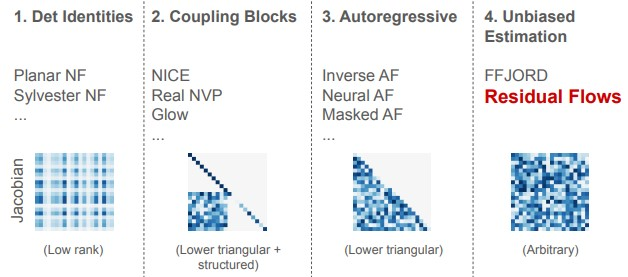

U ovoj vježbi bavit ćemo se modelima Residual Flows i Real NVP.

In [12]:
!pip install normflows


In [13]:
import torch
import numpy as np
import normflows as nf
import torchvision
from sklearn.datasets import make_moons
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm import tqdm
import copy

%matplotlib inline


# Residual Flows

Residual Flows (ResFlows) su posebna klasa NFa koji pripadaju free-form Jacobovijevoj matrici. ResFlows koriste $f = f_L \circ \ldots \circ f_1$ za invertibilno mapiranje, gdje je svaki sloj $f_l$
invertibilna rezidualna mreža s Lipschitz ograničenjima konstante $\kappa$:

\begin{equation*}
    f_l(\mathbf x)=\mathbf x+g_l(\mathbf x), \quad \mathrm{Lip}(g_l) \le \kappa < 1,
\end{equation*}

gdje je $\mathrm{Lip}(g_l)$ <a href="https://www.wikiwand.com/en/Lipschitz_continuity">Lipschitz konstanta</a> funkcije $g$.

Više detalja o ResFlows modelima pogledajte na <a href="https://arxiv.org/pdf/1906.02735.pdf">linku.</a>

Napišite argumente multilayer perceptrona tako da je ulaz dimenzije 2, izlaz dimenzije 2, a  postoji po `hidden_units` neurona po jednom sloju toka.
Lipschitzova konstanta neka iznosi 0.9.

In [14]:
def create_residual_nf(num_layers, hidden_units, hidden_layers):
    flows = []

    latent_size = 2

    for i in range(num_layers):
        param_map = nf.nets.LipschitzMLP([latent_size] + [hidden_units] * (hidden_layers - 1) + [latent_size], init_zeros=True, lipschitz_const=0.9)

        flows.append(nf.flows.Residual(param_map, reduce_memory=True, reverse=True))
        flows.append(nf.flows.ActNorm(latent_size))

    q0 = nf.distributions.DiagGaussian(2, trainable=False)

    model = nf.NormalizingFlow(q0=q0, flows=flows)

    return model


# Real NVP

Real-valued non-volume preserving (Real NVP) se suočava s visoko nelinearnim modelima u visokodimenzionalnim kontinuiranim prostorima kroz najveću vjerojatnost. Kako bi se optimizirala log-vjerojatnost, uvodi se fleksibilnija arhitektura koja omogućuje izračunavanje logaritamske vjerojatnosti na kontinuiranim podatcima.


\begin{equation*}
\log\left(p_X\left(x\right)\right)=\log\left(p_Z\left(f\left(x\right)\right)\right)+\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
\end{equation*}

Može se uočiti da se promjena izvršila prilikom računanja determinante Jacobijeve matrice. Promjena arhitekure nalazi se u "affine coupling layer" blok. Glavna ideja je definirati Jacobijevu matricu kao trokutastu matricu na što jednostavniji način kako bi se efektivno mogla izračunati determinanta. Coupling sloj uključuje jednostavnu operaciju skaliranja i pomaka za neki podskup varijabli u trenutnom sloju, dok drugi dio skupa služi za izračunavanje skaliranja i pomaka. Uz $D$ dimenzionalne ulazne varijable $x$, $y$ kao izlaz iz bloka te $d<D$, unaprijedna propagacija računa se izrazom:

\begin{align*}
y_{1:d} &= x_{1:d} \\
y_{d+1:D} &= x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})
\end{align*}

Reverzna propagacija računa se s izrazom:
\begin{align*}
x_{1:d} &= y_{1:d} \\
x_{d+1:D} &= (y_{d+1:D} - t(y_{1:d})) \odot \exp(-s(y_{1:d}))
\end{align*}

Na sljedećoj slici vizualno su prikazana unaprijedna i reverzna računanja affine coupling sloja.

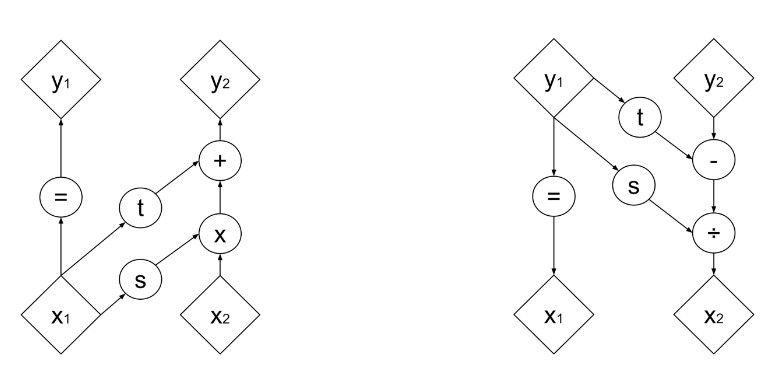

Sada će Jacobijeva matrica poprimiti sljedeći izraz:

\begin{equation}
\frac{\partial y}{\partial x^T} = \left[
\begin{array}{cc}
I_d & 0 \\
\frac{\partial y_{d+1:D}}{\partial x_{1:d}^T} & \text{diag}(\exp[s(x_{1:D})])
\end{array}
\right]
\end{equation}

Više detalja o Real NVP modelima pogledajte na <a href="https://arxiv.org/abs/1605.08803">linku.</a>

Napišite argumente multilayer perceptrona tako da je ulaz dimenzije 1, izlaz dimenzije 2, a  postoji po $hidden\_units$ neurona po jednom sloju toka.

In [15]:
def create_nvp(num_layers, hidden_units):
    flows = []

    for i in range(num_layers):
        param_map = nf.nets.MLP([1, hidden_units, 2], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(2, mode='swap'))

    q0 = nf.distributions.base.DiagGaussian(2, trainable=False)

    model = nf.NormalizingFlow(q0=q0, flows=flows)

    return model


# Podešavanje šuma

Pokretanjem koda iscrtavaju se uzorci iz generiranog skupa podataka dobivenog funkcijom <a href="https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">`make_moons`</a>.
Crta se $2^{20}$ uzoraka, sa različitim šumom. Na grafovima šum varira od 0.05 do 0.3 sa pomakom od 0.05.

Šum je standardom devijacija Gaussovog šuma dodana podatcima.


Pitanje: Kako će se ponašati model ako ga učimo na istom skupu podataka, ali sa različitim razinom šuma? Isprobajte treniranje sa dvije vrijednosti šuma (varijabla `NOISE`) i komentirajte rezultate. Dobivene rezultate spremite.

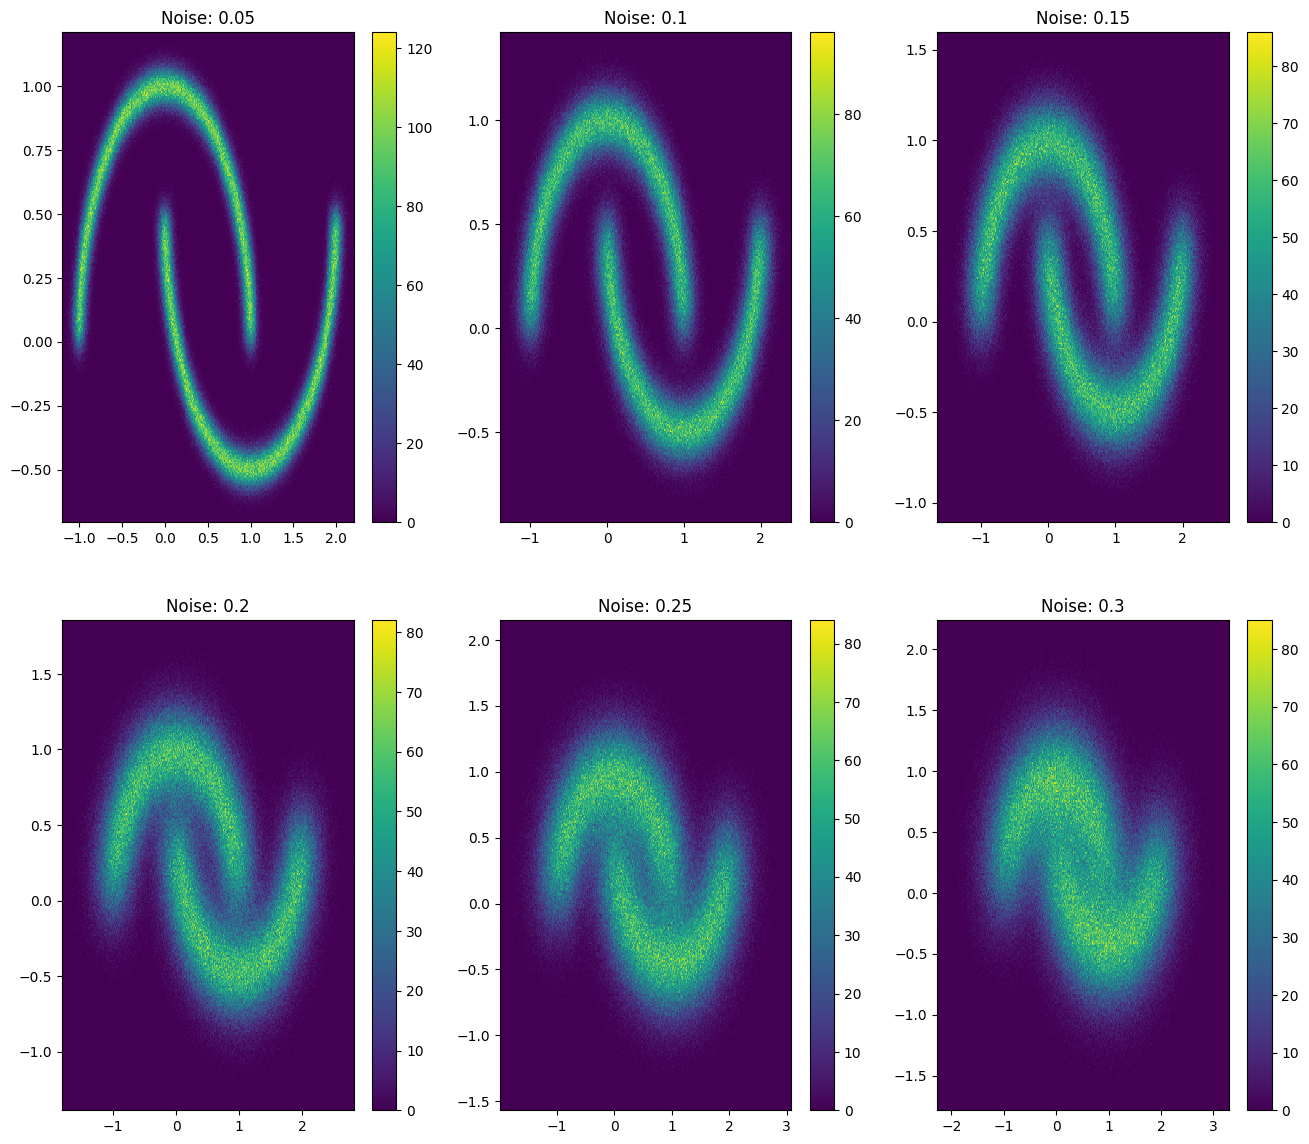

In [16]:
NOISE = 0.1

plt.figure(figsize=(16, 14))


for i, noise in enumerate([0.05, 0.1, 0.15, 0.2, 0.25, 0.3]):
    x_np, _ = make_moons(2 ** 20, noise=noise)
    plt.subplot(2, 3, i + 1)
    plt.hist2d(x_np[:, 0], x_np[:, 1], bins=300)
    plt.colorbar()
    plt.title(f'Noise: {noise}')
plt.show()


In [17]:
grid_size = 100

xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

In [18]:
def draw_model_output(model):

    grid_size = 100

    xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
    zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
    zz = zz.to(DEVICE)

    model.eval()
    log_prob = model.log_prob(zz).to('cpu').view(grid_size, grid_size)

    model.train()
    prob = torch.exp(log_prob)
    prob[torch.isnan(prob)] = 0

    plt.figure(figsize=(6, 6))
    plt.pcolormesh(xx, yy, prob.data.numpy())
    plt.colorbar()
    plt.show()


Isprobajte oba modela mijenjanjem varijable `model_type`. Za svaki model isprobajte dvije do tri kombinacije sa brojem slojeva, brojem skrivenih neurona i brojem skrivenih slojeva. Spremite izlaze svi različitih modela nakon treninga, kako bi se mogli vidjeti rezultate na laboratorijskoj vježbi.
Prokomentirajte rezultate.

Nacrtani graf prikazuje početni izlaz modela prije treniranja. Ona će se mijenjati tijekom treniranja i pokušati naučiti Moons distribuciju.

Odgovor: NVP i ResidualFlow imaju pomak u odnosu jedno na drugo, tj. nisu isti.

In [19]:
grid_size = 100

xx, yy = torch.meshgrid(torch.linspace(-1.5, 2.5, grid_size), torch.linspace(-2, 2, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)


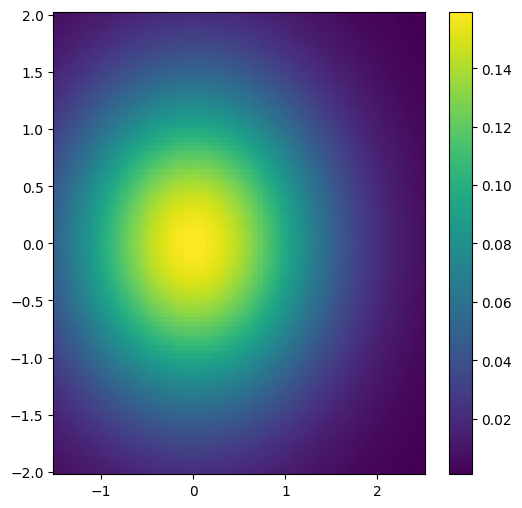

In [20]:
model_type = 'nvp'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

if model_type == 'residual':

    num_layers = 16
    hidden_units = 16
    hidden_layers = 4

    model = create_residual_nf(num_layers=num_layers, hidden_units=hidden_units, hidden_layers=hidden_layers)
    model.to(DEVICE)

if model_type == 'nvp':
    num_layers = 16
    hidden_units = 128

    model = create_nvp(num_layers=num_layers, hidden_units=hidden_units)
    model.to(DEVICE)

zz = zz.to(DEVICE)

draw_model_output(model)


# Funkcija za treniranje modela

U svakoj epohi uzorukuje se `num_samples` uzoraka, te se računa loss preko KL divergencije. Svakih `show_epoch` se pokazuje `zz` izlaz modela koji bi se trebao kroz epohe prilagođavati distribuciji zadanog skupa podataka.
Neka funkcija vraća:
  - zadnje naučeni model
  - model s najmanjim gubitkom
  - vrijednosti funkcije gubitka kroz sve epohe

In [21]:
def train_nf(model, epochs, model_type, optimizer, num_samples=2 ** 9, show_epoch=200):
    loss_array = []

    smallest_loss = np.inf
    best_model = None
    model.train()

    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()

        x_np, _ = make_moons(num_samples, noise=NOISE)
        x = torch.tensor(x_np).float().to(DEVICE)

        loss = model.forward_kld(x)

        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()

            loss_array.append(loss.item())

            if loss < smallest_loss:
                best_model = model

        if model_type == 'residual':
            nf.utils.update_lipschitz(model, 50)

        if (epoch + 1) % show_epoch == 0:
            model.eval()
            log_prob = model.log_prob(zz)

            model.train()
            prob = torch.exp(log_prob.to('cpu').view(grid_size, grid_size))
            prob[torch.isnan(prob)] = 0

            plt.figure(figsize=(6, 6))
            plt.pcolormesh(xx, yy, prob.data.numpy())
            plt.show()

    return model, best_model, loss_array


  4%|▍         | 198/5000 [00:12<07:24, 10.79it/s]

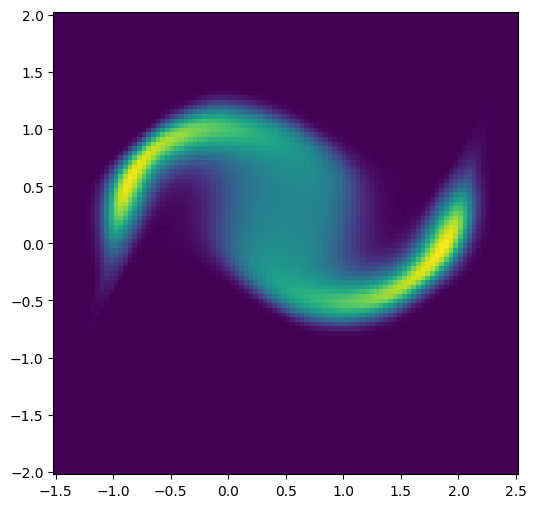

  8%|▊         | 396/5000 [00:24<01:36, 47.95it/s]

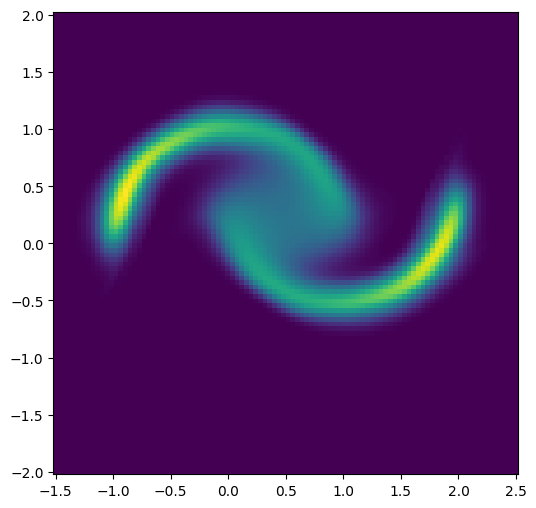

 12%|█▏        | 599/5000 [00:29<01:32, 47.39it/s]

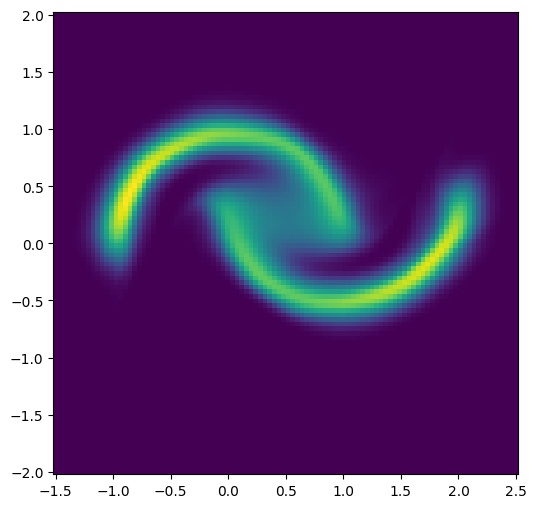

 16%|█▌        | 799/5000 [00:34<01:30, 46.51it/s]

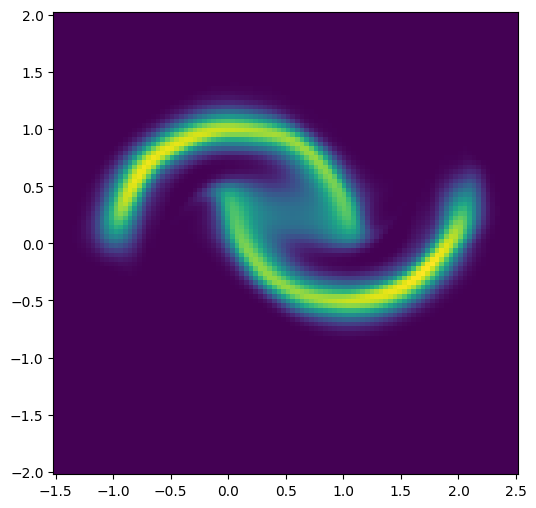

 20%|█▉        | 996/5000 [00:39<02:14, 29.85it/s]

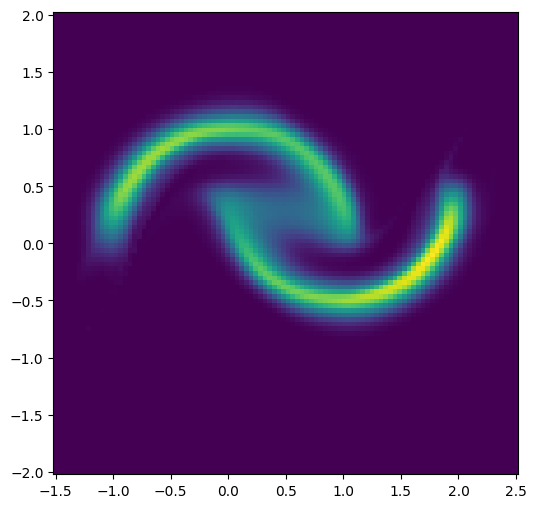

 24%|██▍       | 1195/5000 [00:45<01:22, 45.98it/s]

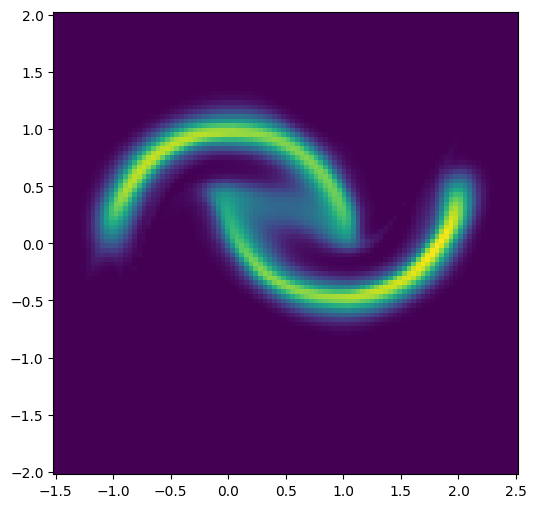

 28%|██▊       | 1395/5000 [00:49<01:20, 44.98it/s]

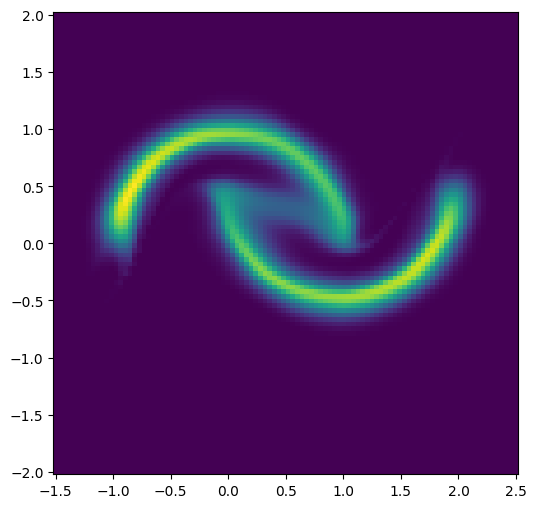

 32%|███▏      | 1598/5000 [00:55<01:24, 40.20it/s]

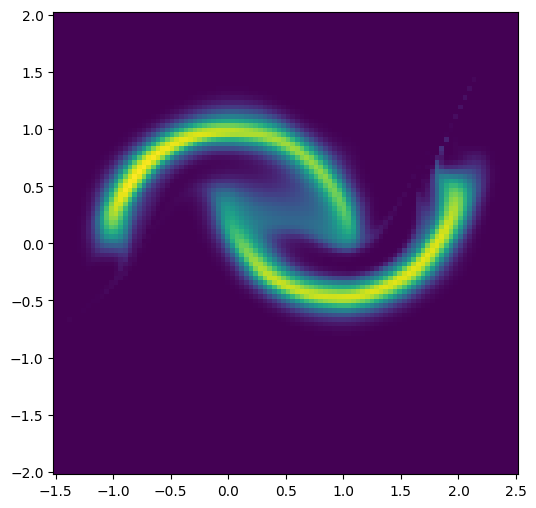

 36%|███▌      | 1798/5000 [01:00<01:11, 44.54it/s]

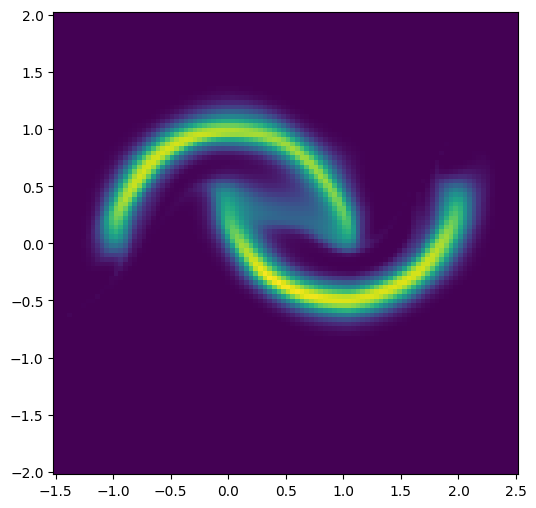

 40%|███▉      | 1998/5000 [01:04<01:05, 45.51it/s]

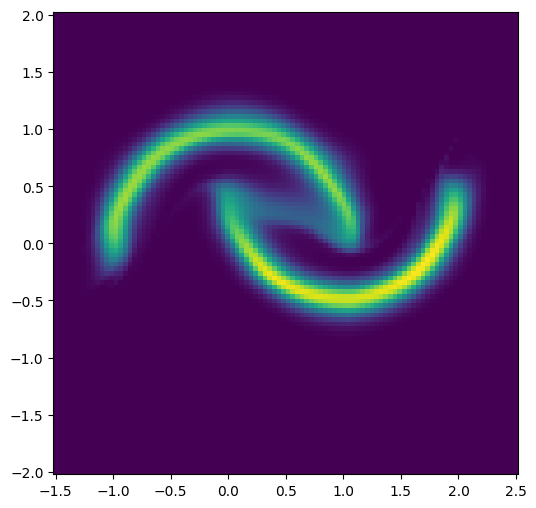

 44%|████▍     | 2199/5000 [01:10<01:01, 45.77it/s]

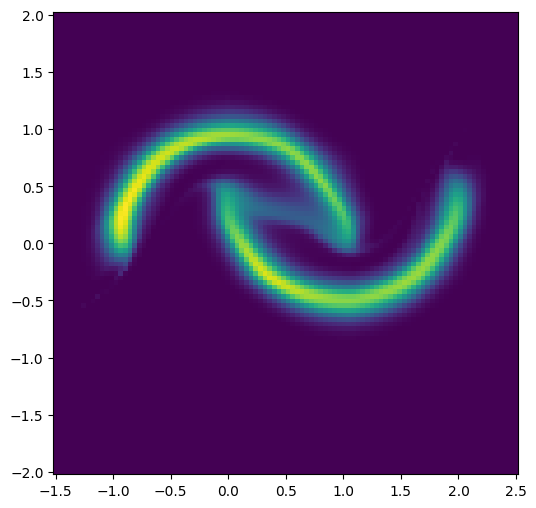

 48%|████▊     | 2399/5000 [01:14<00:56, 45.73it/s]

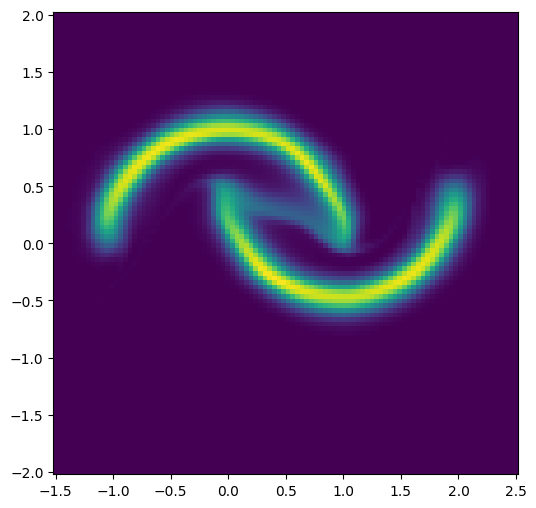

 52%|█████▏    | 2597/5000 [01:19<01:12, 33.20it/s]

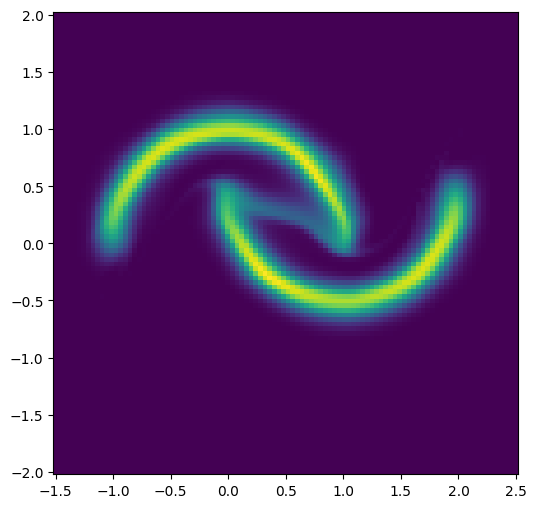

 56%|█████▌    | 2798/5000 [01:24<00:49, 44.81it/s]

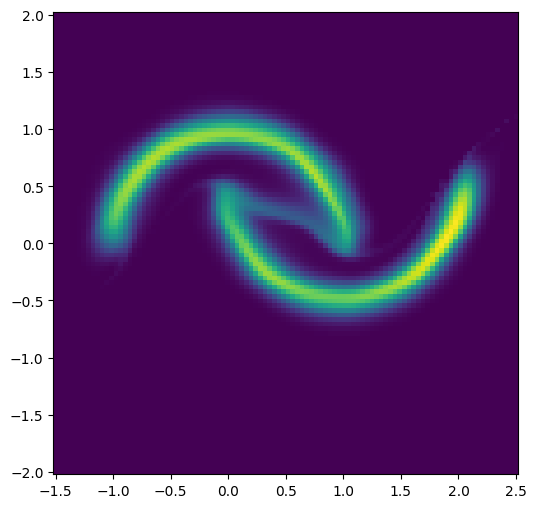

 60%|█████▉    | 2998/5000 [01:29<00:47, 42.15it/s]

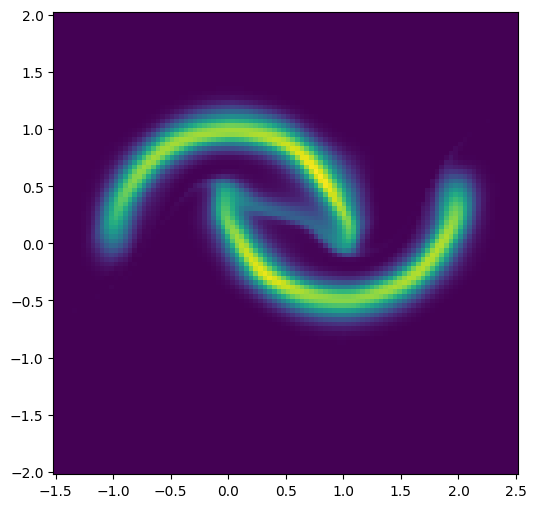

 64%|██████▍   | 3197/5000 [01:34<00:38, 46.77it/s]

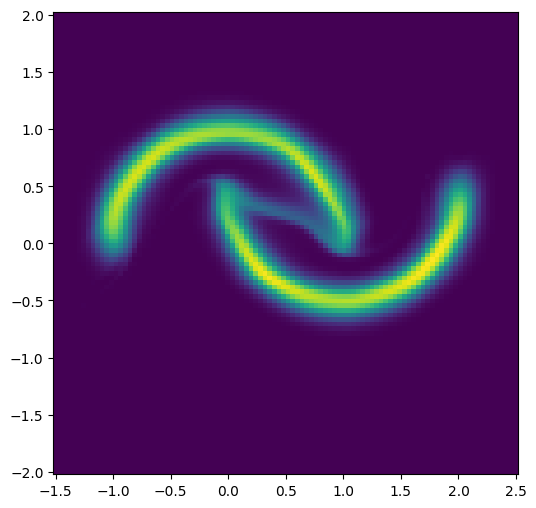

 68%|██████▊   | 3397/5000 [01:39<00:35, 45.49it/s]

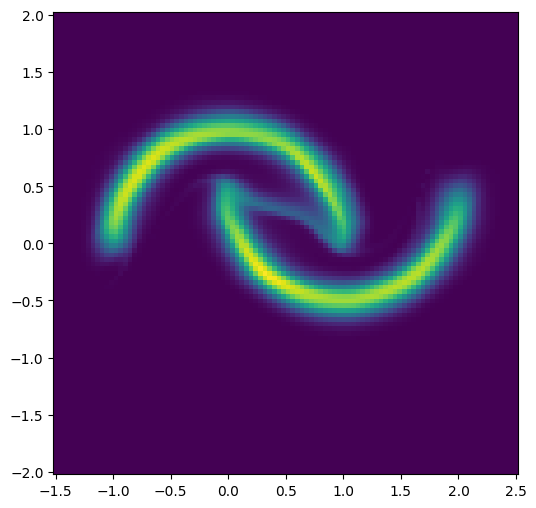

 72%|███████▏  | 3596/5000 [01:44<00:37, 36.98it/s]

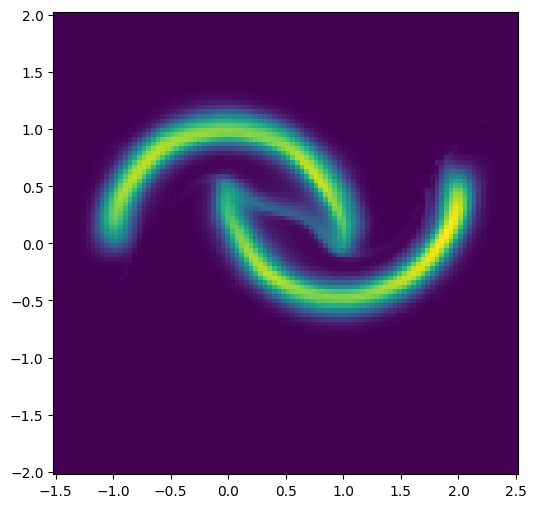

 76%|███████▌  | 3798/5000 [01:49<00:32, 36.75it/s]

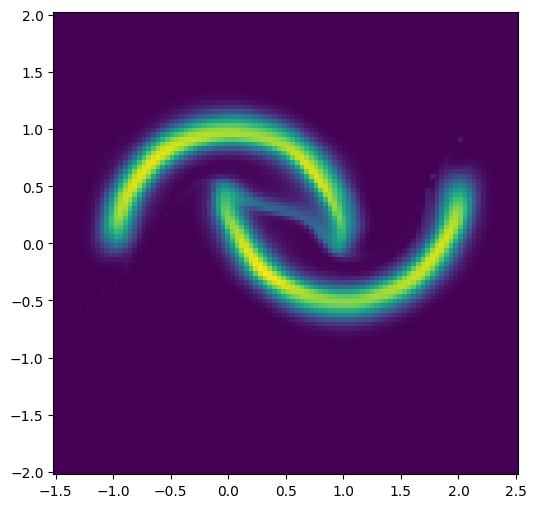

 80%|███████▉  | 3999/5000 [01:55<00:21, 45.91it/s]

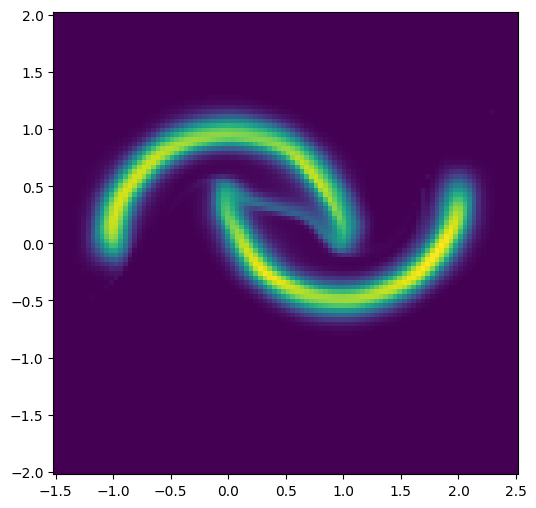

 84%|████████▍ | 4197/5000 [02:00<00:18, 43.53it/s]

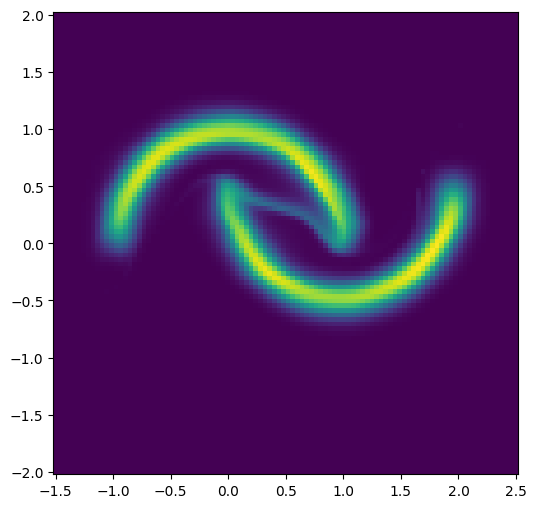

 88%|████████▊ | 4397/5000 [02:05<00:13, 44.74it/s]

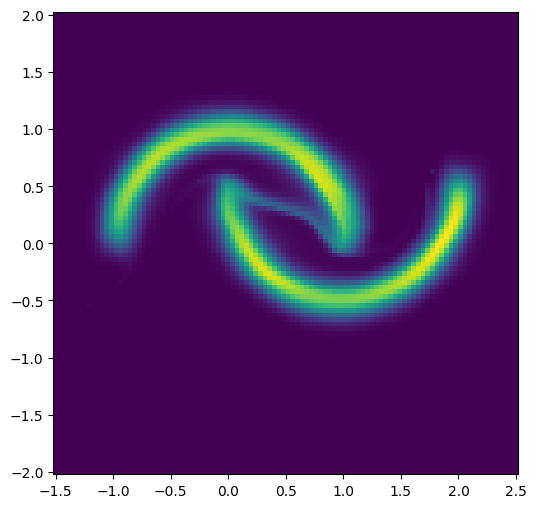

 92%|█████████▏| 4597/5000 [02:10<00:12, 32.74it/s]

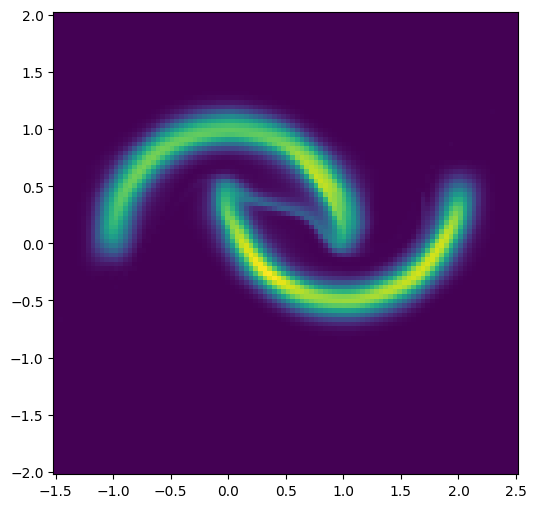

 96%|█████████▌| 4795/5000 [02:15<00:04, 46.46it/s]

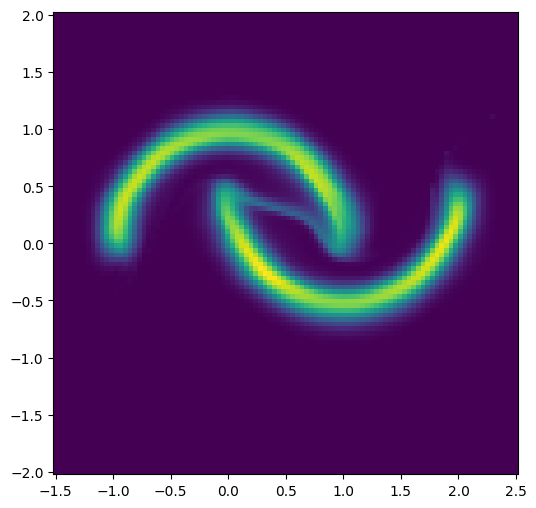

100%|█████████▉| 4996/5000 [02:21<00:00, 45.86it/s]

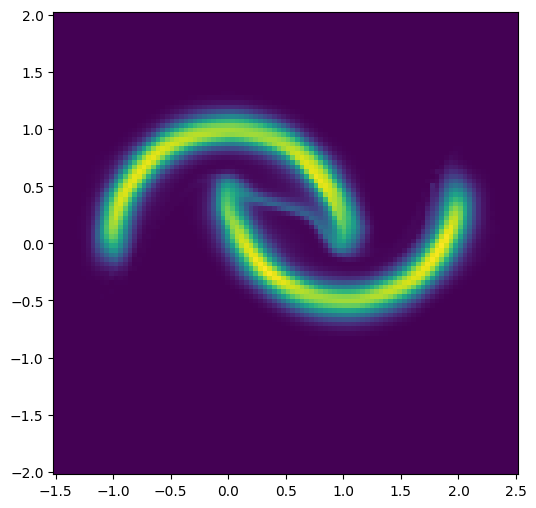

100%|██████████| 5000/5000 [02:21<00:00, 35.37it/s]


In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-5)
epochs = 5000
show_epochs = 500

model, best_model, loss_array = train_nf(model, epochs, 'nvp', optimizer)


**Zadatak**

Prokomentirajte izgled funckije gubitka. `loss_noise` postavite na vrijednost oko 30, kako bi vam graf bio bez outliera. Ukoliko treba probajte prikaz sa drugom vrijednosti ovisno o outlierima.

Odgovor : tokom treniranja, nakon otprilike 3000 epoha prestane poboljšanje te gubitak bude između 1.0 i 1.2 pretežno. Do tad loss monotono pada, uz neke sitne outliere.

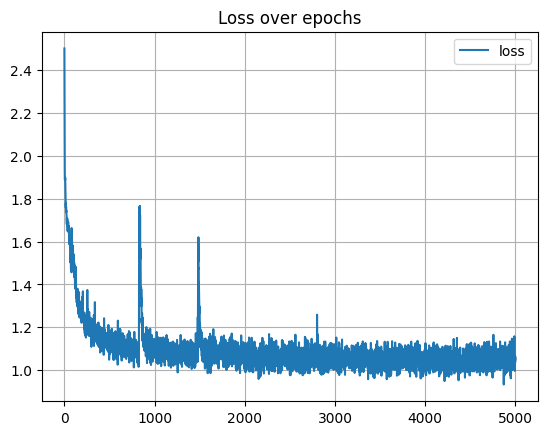

In [35]:
loss_array = np.array(loss_array)

loss_noise = 30

plt.plot(loss_array[loss_array < loss_noise], label='loss')
plt.legend()
plt.grid()
plt.title('Loss over epochs')
plt.show()


**Zadatak**

Prokomentirajte razliku između ResidualFlowa i Real NVP modela. Ispišite vrijednost funkcije gubitka za oba modela.

Odgovor: real NVP je stabilniji i brže se trenira od ResidualFlow-a.

In [ ]:
model.eval()
x_np, _ = make_moons(2 ** 9, noise=0.1)
x = torch.tensor(x_np).float().to(DEVICE)

loss = model.forward_kld(x)

print(f'Loss for ResidualFlow is {loss}')
draw_model_output(model)


Loss for Real NVP is 1.0138061046600342


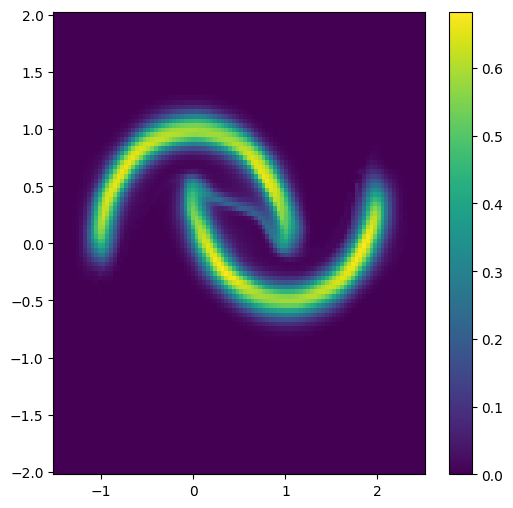

In [27]:
model.eval()
x_np, _ = make_moons(2 ** 9, noise=0.1)
x = torch.tensor(x_np).float().to(DEVICE)

loss = model.forward_kld(x)

print(f'Loss for Real NVP is {loss}')
draw_model_output(model)
